In [55]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, BooleanType, DoubleType, NullType, LongType
from pyspark.sql.functions import (col, length, udf, from_json, split, current_date,
    trim, regexp_replace, when, to_date, date_format, year, month, regexp_extract, from_unixtime, lit, to_timestamp
)

In [56]:
# Initialize SparkSession
spark = SparkSession.builder.appName("ReadAndAnalyzeCreditCardData").getOrCreate()

In [57]:
json_path = "data/cc_transactions.json"

In [58]:
# Read the JSON file and infer schema
df = spark.read \
.option("inferSchema", "true") \
.json(json_path)

In [59]:
# Display the schema to understand the structure of the JSON file
df.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)



In [9]:
## WE check the summary so that if we can find anything interesting
df.summary().show()

24/10/24 23:55:37 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+-----------------+-------------+-------+--------------------+--------------------+--------------------+----------------------+------------------+------------------+------------------+-------------------+--------------------+---------------------+--------------------+
|summary|       Unnamed: 0|              amt|     category| cc_bic|              cc_num|            is_fraud|      merch_eff_time|merch_last_update_time|         merch_lat|        merch_long|     merch_zipcode|           merchant|     personal_detail|trans_date_trans_time|           trans_num|
+-------+-----------------+-----------------+-------------+-------+--------------------+--------------------+--------------------+----------------------+------------------+------------------+------------------+-------------------+--------------------+---------------------+--------------------+
|  count|          1296675|          1296675|      1296675|1296675|             1296675|             1296675|      

### Data Quality Assurance:

We are checking the data types for the values of all columns to find out any unwanted values are there or not. We will be 
continuously checking the data quality while doing any transformations

In [10]:
# Define UDF to classify values
def classify_value(value):
    if isinstance(value, str):
        if value in ["", "NULL", "None", "NA", "Null"]:
            return "string(NA)"
        return "string"
    elif isinstance(value, (int, float)):
        return "numeric"
    elif value is None:
        return "null"
    else:
        return "other"

In [11]:
# Register UDF
classify_udf = udf(classify_value, StringType())

In [12]:
# Apply UDF to each column and group by types
for col_name in df.columns:
    print(f"Column: {col_name}")
    df.withColumn("value_type", classify_udf(df[col_name])) \
       .groupBy("value_type") \
       .count() \
       .show()

Column: Unnamed: 0


+----------+-------+
|value_type|  count|
+----------+-------+
|    string|1296675|
+----------+-------+

Column: amt


+----------+-------+
|value_type|  count|
+----------+-------+
|    string|1296675|
+----------+-------+

Column: category


+----------+-------+
|value_type|  count|
+----------+-------+
|    string|1296675|
+----------+-------+

Column: cc_bic


+----------+------+
|value_type| count|
+----------+------+
|    string|863695|
|string(NA)|432980|
+----------+------+

Column: cc_num


+----------+-------+
|value_type|  count|
+----------+-------+
|    string|1296675|
+----------+-------+

Column: is_fraud


+----------+-------+
|value_type|  count|
+----------+-------+
|    string|1296675|
+----------+-------+

Column: merch_eff_time


+----------+-------+
|value_type|  count|
+----------+-------+
|    string|1296675|
+----------+-------+

Column: merch_last_update_time


+----------+-------+
|value_type|  count|
+----------+-------+
|    string|1296675|
+----------+-------+

Column: merch_lat


+----------+-------+
|value_type|  count|
+----------+-------+
|    string|1296675|
+----------+-------+

Column: merch_long


+----------+-------+
|value_type|  count|
+----------+-------+
|    string|1296675|
+----------+-------+

Column: merch_zipcode


+----------+-------+
|value_type|  count|
+----------+-------+
|    string|1100702|
|      null| 195973|
+----------+-------+

Column: merchant


+----------+-------+
|value_type|  count|
+----------+-------+
|    string|1296675|
+----------+-------+

Column: personal_detail


+----------+-------+
|value_type|  count|
+----------+-------+
|    string|1296675|
+----------+-------+

Column: trans_date_trans_time


+----------+-------+
|value_type|  count|
+----------+-------+
|    string|1296675|
+----------+-------+

Column: trans_num


+----------+-------+
|value_type|  count|
+----------+-------+
|    string|1296675|
+----------+-------+



So, We can see from the first glance

- column cc_bic has some issues with the null value inputs
- column merch_zipcode has null values

In [60]:
# lets fix that by converting the null type values to NullType
# List of null-like strings
null_like_values = ["", "NULL", "None", "NA", "Null"]
df = df.withColumn("cc_bic", when(col("cc_bic").isin(null_like_values), None).otherwise(col("cc_bic")))

In [14]:
## Again checking whether the value has been changed properly
print(f"Column: cc_bic")
df.withColumn("value_type", classify_udf(df["cc_bic"])) \
   .groupBy("value_type") \
   .count() \
   .show()

Column: cc_bic


+----------+------+
|value_type| count|
+----------+------+
|    string|863695|
|      null|432980|
+----------+------+



### JSON Flattening: 

Convert JSON data into a tabular format mentioned in the requirements. We can see from the data that, it has a nested json field named **personal_detail** and inside of it there is another nested field **address**. 

- To flatten the nested fields WE Define schema for the nested JSON fields
- Use from_json to parse the nested JSON string into a structured format
- assign the values getting by dot to the appropriate fields mentioned in the requirements

In [62]:
# Checking the json structure
df.show(1, truncate=False)

+----------+----+--------+-----------+----------------+--------+----------------+----------------------+---------+----------+-------------+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+--------------------------------+
|Unnamed: 0|amt |category|cc_bic     |cc_num          |is_fraud|merch_eff_time  |merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant                  |personal_detail                                                                                                                                                                                                                                                        |trans_date_trans_time|trans_num                       |
+----------+----+--------+--

In [63]:
# To flatten the nested fields WE Define schema for the nested JSON field

personal_detail_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True),
    StructField("lat", StringType(), True),
    StructField("long", StringType(), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", StringType(), True),
    
])

address_schema = StructType([
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True),
])

In [64]:
# Use from_json to parse the nested JSON string into a structured format
df = df.withColumn("personal_detail_parsed", from_json(col("personal_detail"), personal_detail_schema))

In [65]:
df = df.withColumn("address_parsed", from_json(col("personal_detail_parsed.address"), address_schema))

In [66]:
# assign the values getting by dot to the appropriate fields mentioned in the requirements
flattenning_personal_details_column = {
    "person_name" : col("personal_detail_parsed.person_name"), 
    "gender" : col("personal_detail_parsed.gender"),
    "street" : col("address_parsed.street"),
    "city" : col("address_parsed.city"),
    "state" : col("address_parsed.state"),
    "zip" : col("address_parsed.zip"),
    "lat" : col("personal_detail_parsed.lat"),
    "long" : col("personal_detail_parsed.long"),
    "city_pop" : col("personal_detail_parsed.city_pop"),
    "job" : col("personal_detail_parsed.job"),
    "dob" : col("personal_detail_parsed.dob")
}

df = df.withColumns(flattenning_personal_details_column)

In [67]:
# Drop the nested and derived columns used for the calculation
json_flattend_df = df.drop("personal_detail", "personal_detail_parsed", "address_parsed")

In [68]:
json_flattend_df.show(1)

+----------+----+--------+-----------+----------------+--------+----------------+----------------------+---------+----------+-------------+--------------------+---------------------+--------------------+--------------------+------+--------------+--------------+-----+-----+-------+--------+--------+--------------------+----------+
|Unnamed: 0| amt|category|     cc_bic|          cc_num|is_fraud|  merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|            merchant|trans_date_trans_time|           trans_num|         person_name|gender|        street|          city|state|  zip|    lat|    long|city_pop|                 job|       dob|
+----------+----+--------+-----------+----------------+--------+----------------+----------------------+---------+----------+-------------+--------------------+---------------------+--------------------+--------------------+------+--------------+--------------+-----+-----+-------+--------+--------+--------------------+----------+
|   

### Name Derivation:

Extract first and last name columns from person_name:

- The expected format is based on "first, last" but you may
encounter dirty data. Please process the name based on following
example:
§ person_name: "Edward, Sanchez" should result in First:
"Edward" and Last: "Sanchez".

Lets first see the name column. 

In [70]:
json_flattend_df.select("person_name").show(30, truncate=False)

+-------------------------+
|person_name              |
+-------------------------+
|Jennifer,Banks,eeeee     |
|Stephanie,Gill,eeeee     |
|Edward@Sanchez           |
|Jeremy/White, !          |
|Tyler@Garcia             |
|Jennifer,Conner,eeeee    |
|Kelsey, , Richards NOOOO |
|Steven, Williams         |
|Heather, , Chase NOOOO   |
|Melissa@Aguilar          |
|Eddie|Mendez!!!          |
|Theresa@Blackwell        |
|Charles|Robles!!!        |
|Jack@Hill                |
|Christopher@Castaneda    |
|Ronald@Carson            |
|Lisa, Mendez             |
|Nathan,Thomas,eeeee      |
|Justin, Gay              |
|Kenneth, , Robinson NOOOO|
|Gregory|Graham!!!        |
|Jeffrey@Rice             |
|Mary,Wall,eeeee          |
|Susan, , Washington NOOOO|
|Richard@Waters           |
|Jodi/Foster, !           |
|Daniel/Escobar, !        |
|Scott/Martin, !          |
|Brian@Simpson            |
|Aaron@Rogers             |
+-------------------------+
only showing top 30 rows



Wow! we see the name column has so many different kinds of formats. But having a close look at it i found some interesting idea.

- Replace unwanted characters like [@/|!.] with commas
- Split based on comma and take first part as first name, second part as last name
- For the Last name part, I need to consider the case like "Heather, , Chase". so what i did, if 2nd part of splited name is empty and 3rd part has any value, assign the 3rd value. otherwise assign the 2nd value.
- Lastly, for cases like "Susan, , Washington NOOOO", I Extract only the first word from the last name to remove extra characters

In [71]:
# Step 1: Replace unwanted characters with commas
cleaned_df = json_flattend_df.withColumn("person_name_cleaned", regexp_replace(col("person_name"), r"[@/|!.]", ","))

# Step 2: Split based on comma and take first part as first name, second part as last name
splited_df = cleaned_df.withColumn("split_names", split(col("person_name_cleaned"), ","))

# Step 3: Create first_name and last_name columns
json_flattend_df_with_name_parsing = splited_df.withColumn(
    "first", trim(col("split_names").getItem(0))
).withColumn(
    "last", trim(
        when(
            (trim(col("split_names").getItem(1)) == "") & (trim(col("split_names").getItem(2)) != ""),
            trim(col("split_names").getItem(2))
        ).otherwise(trim(col("split_names").getItem(1)))
    )
)

# Step 4: Extract only the first word from the last name to remove extra characters
json_flattend_df_with_name_parsing = json_flattend_df_with_name_parsing.withColumn("last", regexp_extract(col("last"), r'^\w+', 0))
                    

In [72]:
json_flattend_df_with_name_parsing.select("person_name", "person_name_cleaned", "split_names", "first", "last").show(35, truncate=False)

+-------------------------+-------------------------+-----------------------------+-----------+----------+
|person_name              |person_name_cleaned      |split_names                  |first      |last      |
+-------------------------+-------------------------+-----------------------------+-----------+----------+
|Jennifer,Banks,eeeee     |Jennifer,Banks,eeeee     |[Jennifer, Banks, eeeee]     |Jennifer   |Banks     |
|Stephanie,Gill,eeeee     |Stephanie,Gill,eeeee     |[Stephanie, Gill, eeeee]     |Stephanie  |Gill      |
|Edward@Sanchez           |Edward,Sanchez           |[Edward, Sanchez]            |Edward     |Sanchez   |
|Jeremy/White, !          |Jeremy,White, ,          |[Jeremy, White,  , ]         |Jeremy     |White     |
|Tyler@Garcia             |Tyler,Garcia             |[Tyler, Garcia]              |Tyler      |Garcia    |
|Jennifer,Conner,eeeee    |Jennifer,Conner,eeeee    |[Jennifer, Conner, eeeee]    |Jennifer   |Conner    |
|Kelsey, , Richards NOOOO |Kelsey, , 

In [73]:
## Drop Derived columns
json_flattend_df_with_name_parsing = json_flattend_df_with_name_parsing.drop("person_name", "person_name_cleaned", "split_names") 

In [74]:
json_flattend_df_with_name_parsing.show(1, truncate=False)

+----------+----+--------+-----------+----------------+--------+----------------+----------------------+---------+----------+-------------+--------------------------+---------------------+--------------------------------+------+--------------+--------------+-----+-----+-------+--------+--------+-------------------------+----------+--------+-----+
|Unnamed: 0|amt |category|cc_bic     |cc_num          |is_fraud|merch_eff_time  |merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant                  |trans_date_trans_time|trans_num                       |gender|street        |city          |state|zip  |lat    |long    |city_pop|job                      |dob       |first   |last |
+----------+----+--------+-----------+----------------+--------+----------------+----------------------+---------+----------+-------------+--------------------------+---------------------+--------------------------------+------+--------------+--------------+-----+-----+-------+--------+--------+------

### Timestamp Conversion:

All time-related columns (`trans_date_trans_time`, `merch_last_update_time`,`merch_e?_time` columns) must be converted  
to a human-readable timestamp format in UTC +8 timezone (e.g., YYYY-MM-DD HH:MM.SSSSSS Z).

In [76]:
## lets look into the datefields

json_flattend_df_with_name_parsing.select("merch_eff_time", "merch_last_update_time", "trans_date_trans_time").show(20, truncate=False)

### "yyyy-MM-dd HH:mm:ss.SSS"

+----------------+----------------------+---------------------+
|merch_eff_time  |merch_last_update_time|trans_date_trans_time|
+----------------+----------------------+---------------------+
|1325376018798532|1325376018666         |2019-01-01 00:00:18  |
|1325376044867960|132537604479          |2019-01-01 00:00:44  |
|1325376051506840|1325376051286         |2019-01-01 00:00:51  |
|1325376076794698|1325376076365         |2019-01-01 00:01:16  |
|1325376186746376|132537618681          |2019-01-01 00:03:06  |
|1325376248271406|1325376248483         |2019-01-01 00:04:08  |
|1325376282274130|1325376282247         |2019-01-01 00:04:42  |
|1325376308837349|1325376308152         |2019-01-01 00:05:08  |
|1325376318245892|1325376318278         |2019-01-01 00:05:18  |
|1325376361965234|1325376361857         |2019-01-01 00:06:01  |
|1325376383967287|1325376383455         |2019-01-01 00:06:23  |
|1325376413912233|1325376413859         |2019-01-01 00:06:53  |
|1325376416569264|1325376416443         

I found some interesting facts here: 

- 2 of the columns are in unix epoch timestamp, merch_last_update_time and merch_ef_time
- usually for unix epoch time we follow 10, 13,16 digit format but here i found formats of mix digits.
- 
So, i decided to check on the digit lengths to confirm what is the range they reside in between.

In [77]:
# Check on the digit length
# Add a new column for the length of the epoch string
date_columns = json_flattend_df_with_name_parsing.select("merch_eff_time", "merch_last_update_time", "trans_date_trans_time", "category", "is_fraud", "amt")
date_columns = date_columns.withColumn("merch_eff_time(len)", length(col("merch_eff_time"))).withColumn(
    "merch_last_update_time(len)", length(col("merch_last_update_time")))

# Group by category, count occurrences, and calculate relative frequencies
total_count = date_columns.count()
relative_frequencies_for_merch_eff_time = date_columns.groupBy("merch_eff_time(len)") \
                         .count() \
                         .withColumn("frequency", col("count") / total_count)

relative_frequencies_for_merch_last_update_time = date_columns.groupBy("merch_last_update_time(len)") \
                         .count() \
                         .withColumn("frequency", col("count") / total_count)

In [78]:
relative_frequencies_for_merch_eff_time.show()

+-------------------+-------+--------------------+
|merch_eff_time(len)|  count|           frequency|
+-------------------+-------+--------------------+
|                 12|    122|9.408679892802746E-5|
|                 13|   1248|9.624616808375267E-4|
|                 16|1167424|  0.9003212061619141|
|                 15| 116253| 0.08965469373590144|
|                 11|      9|6.940829429116779E-6|
|                 14|  11619|0.008960610792989761|
+-------------------+-------+--------------------+



In [79]:
relative_frequencies_for_merch_last_update_time.show()

+---------------------------+-------+--------------------+
|merch_last_update_time(len)|  count|           frequency|
+---------------------------+-------+--------------------+
|                         12| 116527| 0.08986600343185455|
|                         13|1167213|  0.9001584822719648|
|                         11|  12935|0.009975514296180616|
+---------------------------+-------+--------------------+



so we can see there is inconsistencies in the unix timestamp digits, the range is 11-16

- for column "merch_last_update_time" the values in range 11-13. 13 count is more. 
- for column "merch_eff_time" the values in range 11-16. 16 count is more.
- based on the finding i decided to normalize it to a standard length format for unix time like 13 and 16
- after normalize, i convert the unix timestamp to the required format given in requirements using **from_unixtime** function
  

In [82]:
## so we can see there is inconsistencies in the unix timestamp digits, usual standard is 10, 13, 16, 19 ... 
## but we are getting 11 -16 range, 

# Set timezone to UTC +8
spark.conf.set("spark.sql.session.timeZone", "Asia/Singapore")  # Change as per your requirement

In [81]:
# Function to normalize and convert timestamps
def process_timestamp_column_milliseconds(df_temp, column_name):
    length_col = f"length_{column_name}"  # Length column name (e.g., length_1)
    normalized_col = f"normalized_{column_name}"  # Normalized timestamp column
    human_readable_col = f"timestamp_utc_plus_8_{column_name}"  # Human-readable timestamp column

    return df_temp.withColumn(length_col, length(col(column_name))) \
             .withColumn(
                 normalized_col,
                 when(col(length_col) == 11, col(column_name).cast("long") * 100)  # Seconds -> Milliseconds
                 .when(col(length_col) == 12, col(column_name).cast("long") * 10)  # Seconds -> Milliseconds
                 .when(col(length_col) == 13, col(column_name).cast("long"))  # Already in Milliseconds
                 .when(col(length_col) == 14, col(column_name).cast("long") / 10)  # Microseconds -> Milliseconds
                 .when(col(length_col) == 15, col(column_name).cast("long") / 100)  # Microseconds -> Milliseconds
                 .when(col(length_col) == 16, col(column_name).cast("long") / 1000)  # Nanoseconds -> Milliseconds
                 .otherwise(None)
             ).withColumn(
                 human_readable_col,
                 from_unixtime(col(normalized_col) / 1000, "yyyy-MM-dd HH:mm:ss.SSSSSS")  # Convert to readable timestamp with microseconds
             )

# Function to normalize and convert timestamps
def process_timestamp_column_microseconds(df_temp, column_name):
    length_col = f"length_{column_name}"  # Length column name (e.g., length_1)
    normalized_col = f"normalized_{column_name}"  # Normalized timestamp column
    human_readable_col = f"timestamp_utc_plus_8_{column_name}"  # Human-readable timestamp column

    return df_temp.withColumn(length_col, length(col(column_name))) \
             .withColumn(
                 normalized_col,
                 when(col(length_col) == 11, col(column_name).cast("long") * 100000)  
                 .when(col(length_col) == 12, col(column_name).cast("long") * 10000)  
                 .when(col(length_col) == 13, col(column_name).cast("long") * 1000)  
                 .when(col(length_col) == 14, col(column_name).cast("long") * 100)  
                 .when(col(length_col) == 15, col(column_name).cast("long") * 10)  
                 .when(col(length_col) == 16, col(column_name).cast("long") * 1)  
                 .otherwise(None)
             ).withColumn(
                 human_readable_col,
                 from_unixtime(col(normalized_col) / 1000000, "yyyy-MM-dd HH:mm:ss.SSSSSS")  # Convert to readable timestamp with microseconds
             )

In [83]:
final_flattend_df_with_human_redable_date = process_timestamp_column_microseconds(json_flattend_df_with_name_parsing, "merch_eff_time")
final_flattend_df_with_human_redable_date = process_timestamp_column_milliseconds(
    final_flattend_df_with_human_redable_date, "merch_last_update_time")


In [84]:
final_flattend_df_with_human_redable_date.select("merch_eff_time", "merch_last_update_time", 
                         "timestamp_utc_plus_8_merch_eff_time",
                         "timestamp_utc_plus_8_merch_last_update_time").show(30, truncate=False)

+----------------+----------------------+-----------------------------------+-------------------------------------------+
|merch_eff_time  |merch_last_update_time|timestamp_utc_plus_8_merch_eff_time|timestamp_utc_plus_8_merch_last_update_time|
+----------------+----------------------+-----------------------------------+-------------------------------------------+
|1325376018798532|1325376018666         |2012-01-01 08:00:18.000000         |2012-01-01 08:00:18.000000                 |
|1325376044867960|132537604479          |2012-01-01 08:00:44.000000         |2012-01-01 08:00:44.000000                 |
|1325376051506840|1325376051286         |2012-01-01 08:00:51.000000         |2012-01-01 08:00:51.000000                 |
|1325376076794698|1325376076365         |2012-01-01 08:01:16.000000         |2012-01-01 08:01:16.000000                 |
|1325376186746376|132537618681          |2012-01-01 08:03:06.000000         |2012-01-01 08:03:06.000000                 |
|1325376248271406|132537

In [85]:
## assgning back to the main column
converted_human_readable_column = {
    "merch_eff_time" : col("timestamp_utc_plus_8_merch_eff_time"),
    "merch_last_update_time" : col("timestamp_utc_plus_8_merch_last_update_time")
}

final_flattend_df_with_human_redable_date = final_flattend_df_with_human_redable_date.withColumns(converted_human_readable_column)

## drop derived columns
final_flattend_df_with_human_redable_date = final_flattend_df_with_human_redable_date.drop("timestamp_utc_plus_8_merch_eff_time", 
                                               "timestamp_utc_plus_8_merch_last_update_time",
                                              "normalized_merch_eff_time","normalized_merch_last_update_time",
                                               "length_merch_eff_time","length_merch_last_update_time")

In [86]:
final_flattend_df_with_human_redable_date.show(1, truncate=False)

+----------+----+--------+-----------+----------------+--------+--------------------------+--------------------------+---------+----------+-------------+--------------------------+---------------------+--------------------------------+------+--------------+--------------+-----+-----+-------+--------+--------+-------------------------+----------+--------+-----+
|Unnamed: 0|amt |category|cc_bic     |cc_num          |is_fraud|merch_eff_time            |merch_last_update_time    |merch_lat|merch_long|merch_zipcode|merchant                  |trans_date_trans_time|trans_num                       |gender|street        |city          |state|zip  |lat    |long    |city_pop|job                      |dob       |first   |last |
+----------+----+--------+-----------+----------------+--------+--------------------------+--------------------------+---------+----------+-------------+--------------------------+---------------------+--------------------------------+------+--------------+--------------+--

### Casting to proper data type for later use

In [88]:
updating_columns_datatype = {
    "amt" : col("amt").cast(DoubleType()),
    "Unnamed: 0" : col("Unnamed: 0").cast(LongType()),
    "merch_lat" : col("merch_lat").cast(DoubleType()),
    "merch_long" : col("merch_long").cast(DoubleType())   
}

final_flattend_df_with_human_redable_date = final_flattend_df_with_human_redable_date.withColumns(updating_columns_datatype)

In [89]:
final_flattend_df_with_human_redable_date.printSchema()

root
 |-- Unnamed: 0: long (nullable = true)
 |-- amt: double (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- first: string (nullable = true)


## Handling PII Data

Personal Identifiable Information (PII) is defined as: Any representation of information that permits the identity of an individual to whom the information applies to be reasonably inferred by either direct or indirect means.  

In our dataset we have the following PII columns:  

 gender: string (nullable = true)  
 street: string (nullable = true)  
 city: string (nullable = true)  
 state: string (nullable = true)  
 zip: string (nullable = true)  
 lat: string (nullable = true)  
 long: string (nullable = true)  
 city_pop: string (nullable = true)  
 job: string (nullable = true)  
 dob: string (nullable = true)  
 first: string (nullable = true)  
 last: string (nullable = true)  

**One solution is to encrypt the PII data  
we will be uisng a library named cryptography to encrypt and decrypt data**

In [90]:
# import necessary libs
from cryptography.fernet import Fernet

In [91]:
# Step 2: Create UDFs for encryption and decryption
# Encrypt UDF
def encrypt_value(value):
    if value is not None:
        return cipher.encrypt(value.encode()).decode()
    return None

# Decrypt UDF
def decrypt_value(value):
    if value is not None:
        return cipher.decrypt(value.encode()).decode()
    return None


In [92]:
# Register UDFs
encrypt_udf = udf(encrypt_value, StringType())
decrypt_udf = udf(decrypt_value, StringType())

In [93]:
# Step 1: Generate a key for encryption and decryption
key = Fernet.generate_key()
cipher = Fernet(key)

# lets take a subset of PII columns for testing
pii_data = final_flattend_df_with_human_redable_date.select("first", "last")

# Step 3: Apply encryption to PII columns
# Let's assume 'first' and 'last' are the PII columns
pii_data_encrypted = pii_data.withColumn("encrypted_first", encrypt_udf(col("first"))) \
                 .withColumn("encrypted_last", encrypt_udf(col("last")))

# Step 4: Apply decryption when needed
pii_data_decrepted = pii_data_encrypted.withColumn("decrypted_first", decrypt_udf(col("encrypted_first"))) \
                           .withColumn("decrypted_last", decrypt_udf(col("encrypted_last")))


           


In [94]:
pii_data_decrepted.show(10)

+---------+--------+--------------------+--------------------+---------------+--------------+
|    first|    last|     encrypted_first|      encrypted_last|decrypted_first|decrypted_last|
+---------+--------+--------------------+--------------------+---------------+--------------+
| Jennifer|   Banks|gAAAAABnGow4BnObx...|gAAAAABnGow4UDKWM...|       Jennifer|         Banks|
|Stephanie|    Gill|gAAAAABnGow4Slm-k...|gAAAAABnGow4-a5ss...|      Stephanie|          Gill|
|   Edward| Sanchez|gAAAAABnGow4IWhw8...|gAAAAABnGow44mavL...|         Edward|       Sanchez|
|   Jeremy|   White|gAAAAABnGow40zc3Z...|gAAAAABnGow41HxwA...|         Jeremy|         White|
|    Tyler|  Garcia|gAAAAABnGow44bzoL...|gAAAAABnGow4FLi0F...|          Tyler|        Garcia|
| Jennifer|  Conner|gAAAAABnGow4SUwpm...|gAAAAABnGow4MuzVE...|       Jennifer|        Conner|
|   Kelsey|Richards|gAAAAABnGow4Szmzc...|gAAAAABnGow4_1_n1...|         Kelsey|      Richards|
|   Steven|Williams|gAAAAABnGow4L6aSK...|gAAAAABnGow4fb2D2..

## Some Potential analysis:
- Fraud vs Non-Fraud Transactions
- Transaction Amount Distribution
- Merchant Category Analysis
- Transaction Trend Over Time
- Fraud Detection by Merchant Category
- Transaction Amounts by State
- Age Analysis of Cardholders

so, before jumping into the analysis, we need to convert some relavent columns

In [44]:
dataset_for_analysis = final_flattend_df_with_human_redable_date

# Convert relevant columns to date format for time-based analysis
dataset_for_analysis = dataset_for_analysis.withColumn("trans_date_trans_time", to_date(col("trans_date_trans_time")))
dataset_for_analysis = dataset_for_analysis.withColumn("trans_year_month", date_format(col("trans_date_trans_time"), 'yyyy-MM'))

### Fraud vs. Non-Fraud Transactions:
- **Visualizations:**  
   - Bar plot of the count of fraud (is_fraud == 1) vs. non-fraud (is_fraud == 0) transactions.
   - Comparison of average transaction amounts between fraud and non-fraud cases using a boxplot.
- **Insights:**
   - Identify if fraudulent transactions tend to involve higher or lower amounts.

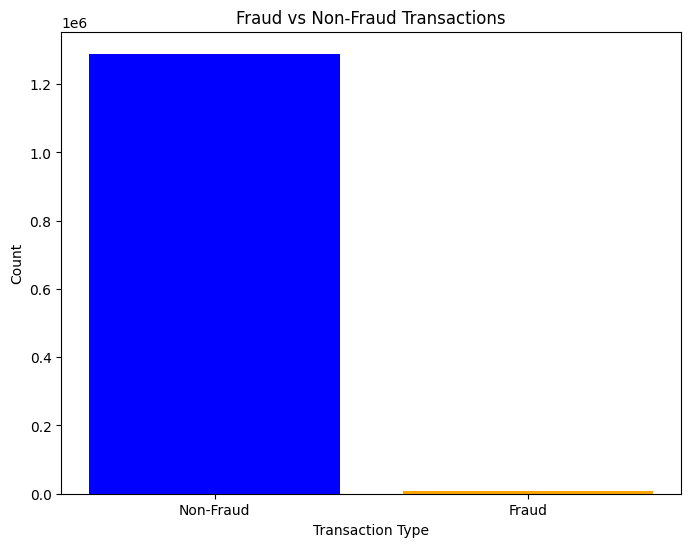

In [45]:
# Count of fraud vs non-fraud
fraud_counts = dataset_for_analysis.groupBy("is_fraud").count().collect()

# Extract data for plotting
labels = ['Non-Fraud', 'Fraud']
fraud_values = [row['count'] for row in fraud_counts]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(labels, fraud_values, color=['blue', 'orange'])
plt.title('Fraud vs Non-Fraud Transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

### Transaction Amount Distribution:
- **Visualizations:**  
   - Histogram or KDE plot to show the distribution of transaction amounts (amt).
- **Insights:**
   - Detect outliers or unusual patterns in transaction amounts.

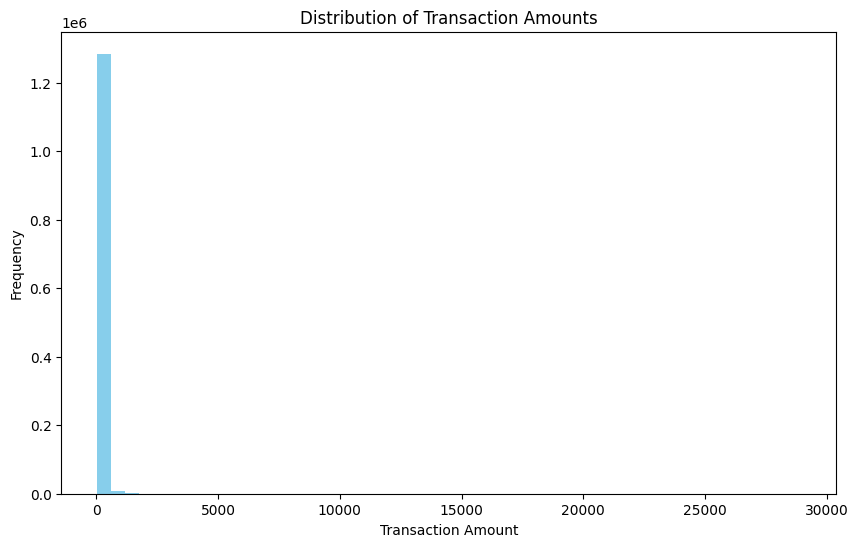

In [46]:
# Collect transaction amount data
amt_data = dataset_for_analysis.select("amt").rdd.flatMap(lambda x: x).collect()

# Plot transaction amount distribution
plt.figure(figsize=(10, 6))
plt.hist(amt_data, bins=50, color='skyblue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

### Merchant Category Analysis:
- **Visualizations:**  
   - Bar plot of transaction counts by merchant category (category)
   - Mean/median transaction amounts by category.
- **Insights:**
   - Spot categories with frequent transactions and high/low average transaction values.

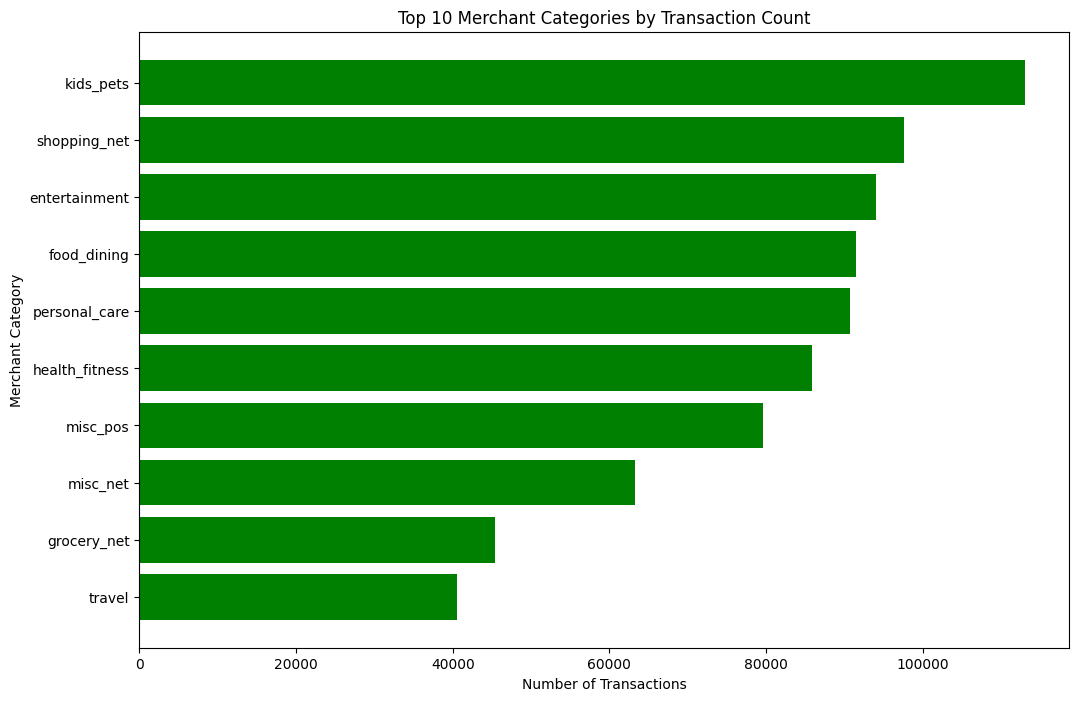

In [48]:
# Group by merchant category and count transactions
category_counts = dataset_for_analysis.groupBy("category").count().orderBy("count", ascending=True).limit(10).collect()

# Extract data for plotting
categories = [row['category'] for row in category_counts]
counts = [row['count'] for row in category_counts]

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(categories, counts, color='green')
plt.title('Top 10 Merchant Categories by Transaction Count')
plt.xlabel('Number of Transactions')
plt.ylabel('Merchant Category')
plt.show()

### Time-Based Patterns:
- **Visualizations:**  
   - Time series plot of transactions over time using trans_date_trans_time
- **Insights:**
   - Detect trends, spikes, or seasonality in transaction volumes over time.

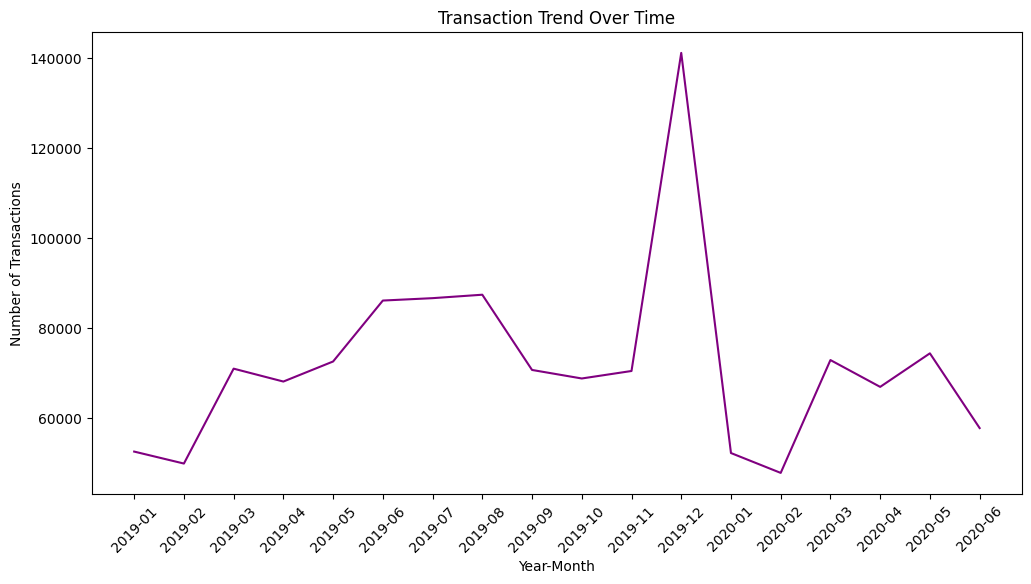

In [49]:
# Group transactions by year-month
transaction_trend = dataset_for_analysis.groupBy("trans_year_month").count().orderBy("trans_year_month").collect()

# Extract data for plotting
months = [row['trans_year_month'] for row in transaction_trend]
transaction_counts = [row['count'] for row in transaction_trend]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(months, transaction_counts, color='purple')
plt.title('Transaction Trend Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

### Fraud Detection by Merchant Category:
- You can investigate which merchant categories have the highest number of fraud cases. This could help identify vulnerable categories.

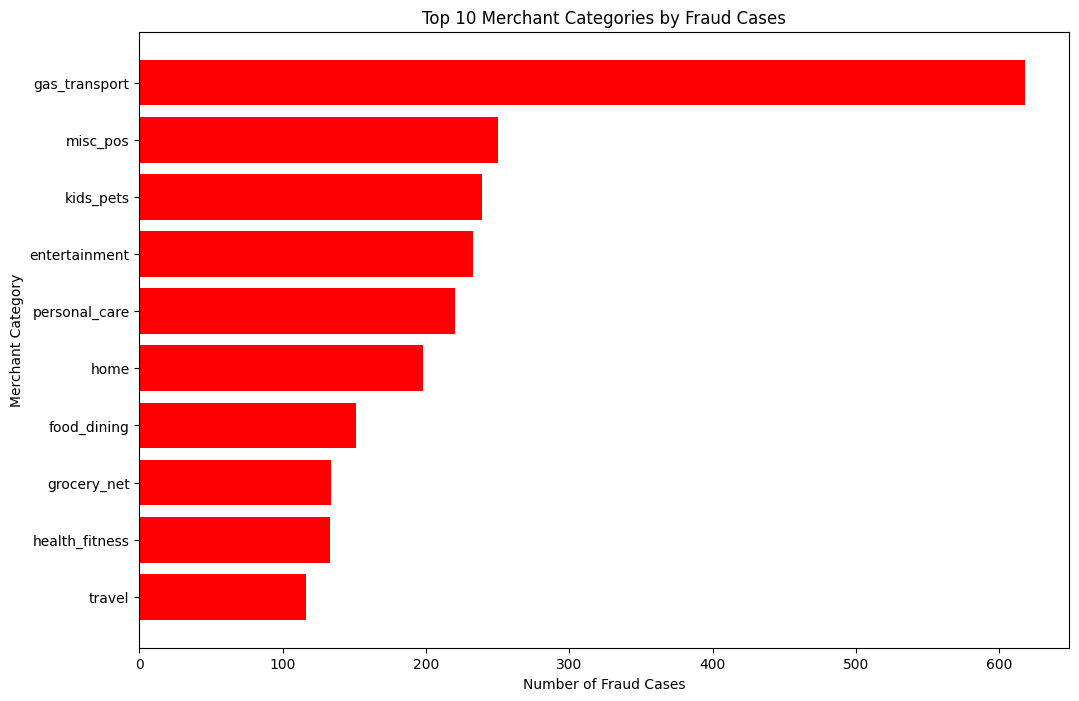

In [51]:
# Group by category and fraud cases to see which categories have the most fraud
fraud_by_category = dataset_for_analysis.groupBy("category", "is_fraud").count().filter(col("is_fraud") == 1).orderBy("count", ascending=True).limit(10).collect()

# Extract data for plotting
categories = [row['category'] for row in fraud_by_category]
fraud_counts = [row['count'] for row in fraud_by_category]

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(categories, fraud_counts, color='red')
plt.title('Top 10 Merchant Categories by Fraud Cases')
plt.xlabel('Number of Fraud Cases')
plt.ylabel('Merchant Category')
plt.show()

### Transaction Amounts by State:
- You can investigate which merchant categories have the highest number of fraud cases. This could help identify vulnerable categories.

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


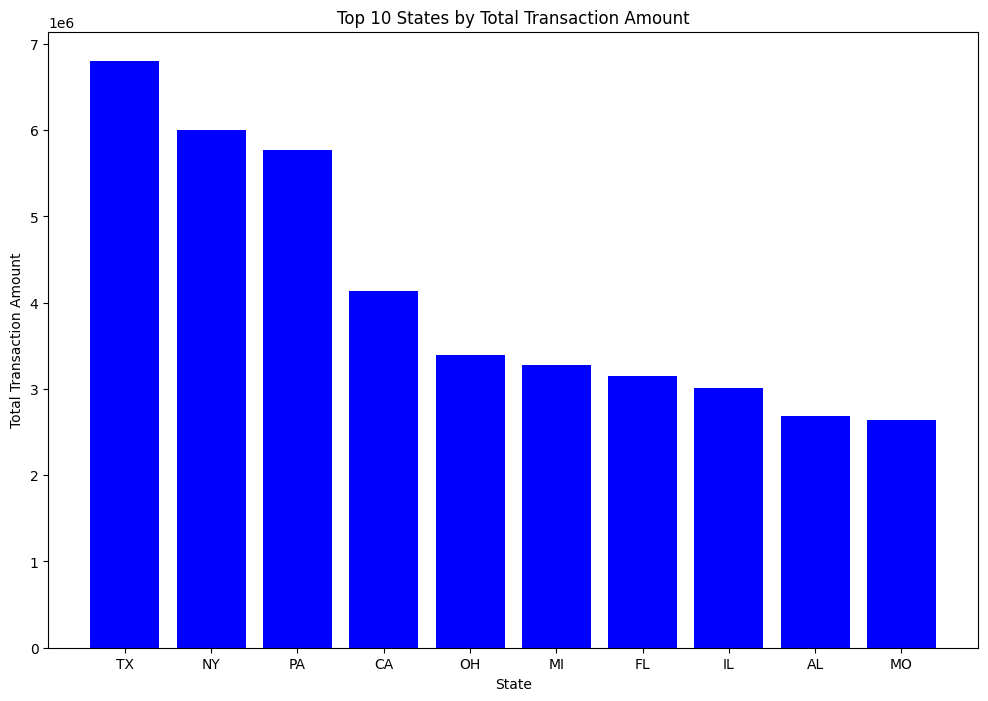

In [52]:
# Group by state and sum transaction amounts
amount_by_state = dataset_for_analysis.groupBy("state").sum("amt").orderBy("sum(amt)", ascending=False).limit(10).collect()

# Extract data for plotting
states = [row['state'] for row in amount_by_state]
amounts = [row['sum(amt)'] for row in amount_by_state]

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(states, amounts, color='blue')
plt.title('Top 10 States by Total Transaction Amount')
plt.xlabel('State')
plt.ylabel('Total Transaction Amount')
plt.show()

### Age Analysis of Cardholders:
- You can investigate which merchant categories have the highest number of fraud cases. This could help identify vulnerable categories.

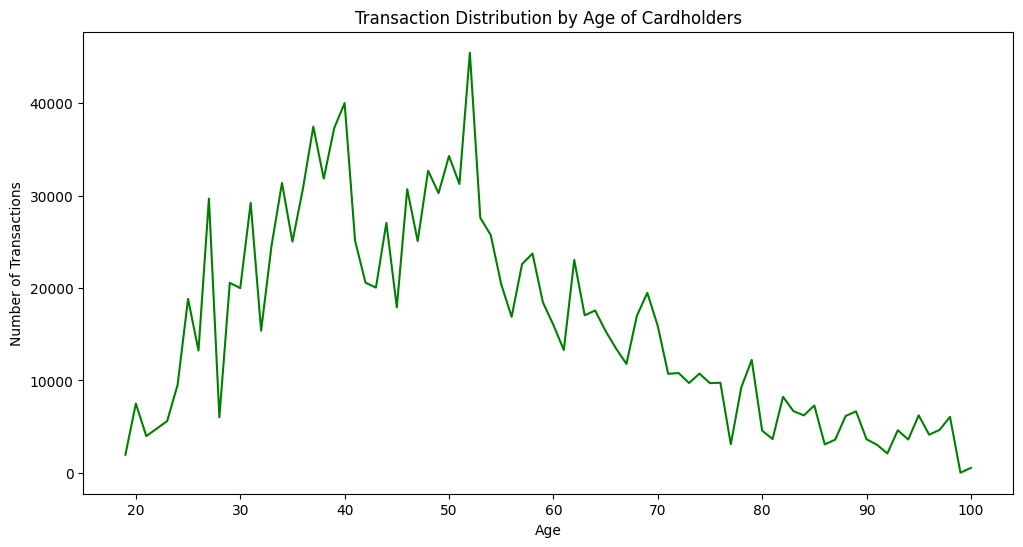

In [54]:
# Calculate age of cardholders
dataset_for_analysis = dataset_for_analysis.withColumn("age", year(current_date()) - year(col("dob")))

# Group by age and count transactions
age_distribution = dataset_for_analysis.groupBy("age").count().orderBy("age").collect()

# Extract data for plotting
ages = [row['age'] for row in age_distribution]
age_counts = [row['count'] for row in age_distribution]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(ages, age_counts, color='green')
plt.title('Transaction Distribution by Age of Cardholders')
plt.xlabel('Age')
plt.ylabel('Number of Transactions')
plt.show()

Some other possible analysis could be done, viz:

### Demographic Insights:
- **Visualizations:**  
   - Bar plot of transaction counts by gender (gender) and occupation (job).
- **Insights:**
   - See if certain demographics (gender, job) are associated with higher transaction amounts or fraud occurrences.
 
### Geographical Insights:
- **Visualizations:**  
   - Heatmap of transaction volumes based on state or city_pop to visualize transaction density.
   - Scatter plot of merchant latitude (merch_lat) and longitude (merch_long) to see geographical spread.
- **Insights:**
   - Explore if certain regions have a higher incidence of fraud or transaction activity.

In [50]:
# we might need to save the processed/transformed clean data to a storage somewhere
output_path = "data/cleaned_transaction_data"

# Write the DataFrame to CSV
final_flattend_df_with_human_redable_date.write.option("header", True).option("delimiter", ",").mode("overwrite").csv(output_path)